# **Quantum states reconstruction of three-qubit states**

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector


from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import amplitude_damping_error
from qiskit.providers.aer.noise import kraus_error


from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

TensorFlow version: 2.11.0


In [2]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation

In [3]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [5]:
#Function which computes the components of the Bloch vector, given the density matrix 

#Here we define the identity matrix and the Pauli matrices for dimension 2 (one qubit)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

In [6]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [7]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## (In)Fidelity Implementation

In [8]:
#get Bloch vector for 3-qubit states
pauli_basis1q = np.array([I, X, Y, Z])
pauli_basis2q = np.array([np.kron(a,b) for a in pauli_basis1q for b in pauli_basis1q])

pauli_basis3q = np.array([np.kron(a,b) for a in pauli_basis2q for b in pauli_basis1q])
pauli_basis3q_modified = pauli_basis3q[1:]


#function which returns bloch components from density matrix
def bloch_coeffs(rho):
    c = []
    for p in pauli_basis3q_modified:
        c.append(np.trace(rho @ p))
    return np.array(c)

In [9]:
I_8 = tf.eye(8, dtype=tf.complex64)


def fid_threeq(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk', pauli_basis3q_modified, a)
   el_b = tf.einsum('ijk,mi->mjk', pauli_basis3q_modified, b)
   rho_a = 0.125 *(el_a + I_8)
   rho_b = 0.125 * (el_b +I_8)
   fidelity = tf.linalg.trace(rho_a @ rho_b) 
   return fidelity     

In [10]:
#Define Infidelity
@tf.function
def infidelity3(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk', pauli_basis3q_modified, a)
   el_b = tf.einsum('ijk,mi->mjk', pauli_basis3q_modified, b)
   rho_a = 0.125 *(el_a + I_8)
   rho_b = 0.125 * (el_b +I_8)
   fidelity = tf.linalg.trace(rho_a @ rho_b) 
   infidelity = 1 - fidelity
   infidelity = tf.cast(infidelity, dtype = tf.float32)
   return infidelity 

## Noise Model

In [11]:
num_qubits = 1

#PROBABILITIES FOR BIT, PHASE, BIT-PHASE FLIP OR DEPOLARIZING ERRORS
p_error = 0.2
    
#PROBABILITIES FOR GENERAL PAULI ERROR
p_0=0.7
p_1=0.2
p_2=0.05
p_3=0.05
    
#PARAMETERS FOR KRAUS ERROR
alpha = np.pi / 3
beta = np.pi / 6
    
A_0 = np.array([[np.cos (alpha), 0], [0, np.cos (beta)]])
A_1 = np.array([[0, np.sin (beta)], [np.sin (alpha), 0]])
Kraus_operators = [A_0, A_1]
    
bit_flip_error = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip_error = pauli_error([('Z', p_error), ('I', 1 - p_error)])
bit_phase_flip_error = pauli_error([('Y', p_error), ('I', 1 - p_error)])
dep_error = depolarizing_error(p_error, num_qubits)
general_pauli_error = pauli_error([('X', p_1), ('Y', p_2), ('Z', p_3), ('I', p_0)])
AD_error = amplitude_damping_error (0.3, 0.5) 
k_error = kraus_error(Kraus_operators)

In [12]:
#applies error whenever an identity gate appears in the circuit (compatibly with the probability errors)
def qsk_add_error(error_type):
    if error_type == 'bit':
        noise_model.add_all_qubit_quantum_error(bit_flip_error, ["id"])
    if error_type == 'phase':
        noise_model.add_all_qubit_quantum_error(phase_flip_error, ["id"])
    if error_type == 'bit-phase':
        noise_model.add_all_qubit_quantum_error(bit_phase_flip_error, ["id"])
    if error_type == 'depolarizing':
        noise_model.add_all_qubit_quantum_error(dep_error, ["id"])
    if error_type == 'Gpauli':
        noise_model.add_all_qubit_quantum_error(general_pauli_error, ["id"])
    if error_type == 'AD':
        noise_model.add_all_qubit_quantum_error(AD_error, ["id"])
    if error_type == 'Kraus':
        noise_model.add_all_qubit_quantum_error(k_error, ["id"])

## State Reconstruction 

In [13]:
data = generate_Haar_data(3, 2000) 
density_matrix_noise_free = [*map(get_density_matrix, data)] 

In [14]:
num_qubits = 3
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):
    #print(f"Sample: {i+1} / {len(data)}")

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.id(2) #applies identity to the third qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(bit_flip_error, ["id"], [1])
    noise_model.add_quantum_error(bit_phase_flip_error, ["id"], [2])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [15]:
bloch_vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]
bloch_vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]

In [42]:
x_train_list = bloch_vectors_with_noise[:900]
y_train_list = bloch_vectors_noise_free[:900]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = bloch_vectors_with_noise[1000:1500]
y_val_list = bloch_vectors_noise_free[1000:1500]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = bloch_vectors_with_noise[1500:]
y_test_list = bloch_vectors_noise_free[1500:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

## MSE

In [43]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(63,)),
  tf.keras.layers.Dense(128, activation='relu'), 
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(63)
  ])

In [44]:
# Compile model
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.0002)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [45]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=800)

Epoch 1/800
9/9 [==============================] - 2s 40ms/step - loss: 0.1136 - val_loss: 0.1124
Epoch 2/800
9/9 [==============================] - 0s 13ms/step - loss: 0.1115 - val_loss: 0.1110
Epoch 3/800
9/9 [==============================] - 0s 14ms/step - loss: 0.1101 - val_loss: 0.1100
Epoch 4/800
9/9 [==============================] - 0s 13ms/step - loss: 0.1090 - val_loss: 0.1091
Epoch 5/800
9/9 [==============================] - 0s 14ms/step - loss: 0.1079 - val_loss: 0.1082
Epoch 6/800
9/9 [==============================] - 0s 14ms/step - loss: 0.1068 - val_loss: 0.1073
Epoch 7/800
9/9 [==============================] - 0s 14ms/step - loss: 0.1056 - val_loss: 0.1062
Epoch 8/800
9/9 [==============================] - 0s 12ms/step - loss: 0.1042 - val_loss: 0.1050
Epoch 9/800
9/9 [==============================] - 0s 17ms/step - loss: 0.1027 - val_loss: 0.1036
Epoch 10/800
9/9 [==============================] - 0s 16ms/step - loss: 0.1010 - val_loss: 0.1020
Epoch 11/800
9/9 [=

Epoch 84/800
9/9 [==============================] - 0s 15ms/step - loss: 0.0114 - val_loss: 0.0146
Epoch 85/800
9/9 [==============================] - 0s 17ms/step - loss: 0.0111 - val_loss: 0.0140
Epoch 86/800
9/9 [==============================] - 0s 18ms/step - loss: 0.0107 - val_loss: 0.0137
Epoch 87/800
9/9 [==============================] - 0s 13ms/step - loss: 0.0104 - val_loss: 0.0133
Epoch 88/800
9/9 [==============================] - 0s 12ms/step - loss: 0.0101 - val_loss: 0.0129
Epoch 89/800
9/9 [==============================] - 0s 14ms/step - loss: 0.0098 - val_loss: 0.0126
Epoch 90/800
9/9 [==============================] - 0s 14ms/step - loss: 0.0095 - val_loss: 0.0122
Epoch 91/800
9/9 [==============================] - 0s 15ms/step - loss: 0.0092 - val_loss: 0.0119
Epoch 92/800
9/9 [==============================] - 0s 15ms/step - loss: 0.0089 - val_loss: 0.0115
Epoch 93/800
9/9 [==============================] - 0s 17ms/step - loss: 0.0086 - val_loss: 0.0112
Epoch 94/8

9/9 [==============================] - 0s 13ms/step - loss: 6.4816e-04 - val_loss: 0.0013
Epoch 166/800
9/9 [==============================] - 0s 12ms/step - loss: 6.3463e-04 - val_loss: 0.0012
Epoch 167/800
9/9 [==============================] - 0s 12ms/step - loss: 6.2343e-04 - val_loss: 0.0012
Epoch 168/800
9/9 [==============================] - 0s 11ms/step - loss: 6.0969e-04 - val_loss: 0.0012
Epoch 169/800
9/9 [==============================] - 0s 12ms/step - loss: 5.9262e-04 - val_loss: 0.0012
Epoch 170/800
9/9 [==============================] - 0s 12ms/step - loss: 5.7384e-04 - val_loss: 0.0011
Epoch 171/800
9/9 [==============================] - 0s 13ms/step - loss: 5.6203e-04 - val_loss: 0.0011
Epoch 172/800
9/9 [==============================] - 0s 14ms/step - loss: 5.5188e-04 - val_loss: 0.0011
Epoch 173/800
9/9 [==============================] - 0s 13ms/step - loss: 5.4008e-04 - val_loss: 0.0011
Epoch 174/800
9/9 [==============================] - 0s 18ms/step - loss: 5.23

9/9 [==============================] - 0s 24ms/step - loss: 1.1985e-04 - val_loss: 4.3275e-04
Epoch 242/800
9/9 [==============================] - 0s 21ms/step - loss: 1.1718e-04 - val_loss: 4.3066e-04
Epoch 243/800
9/9 [==============================] - 0s 21ms/step - loss: 1.1572e-04 - val_loss: 4.2805e-04
Epoch 244/800
9/9 [==============================] - 0s 18ms/step - loss: 1.1231e-04 - val_loss: 4.2006e-04
Epoch 245/800
9/9 [==============================] - 0s 21ms/step - loss: 1.1055e-04 - val_loss: 4.1736e-04
Epoch 246/800
9/9 [==============================] - 0s 20ms/step - loss: 1.0864e-04 - val_loss: 4.1038e-04
Epoch 247/800
9/9 [==============================] - 0s 19ms/step - loss: 1.0390e-04 - val_loss: 4.0390e-04
Epoch 248/800
9/9 [==============================] - 0s 17ms/step - loss: 1.0203e-04 - val_loss: 4.0122e-04
Epoch 249/800
9/9 [==============================] - 0s 19ms/step - loss: 1.0118e-04 - val_loss: 3.9718e-04
Epoch 250/800
9/9 [=======================

Epoch 317/800
9/9 [==============================] - 0s 12ms/step - loss: 2.5469e-05 - val_loss: 2.3093e-04
Epoch 318/800
9/9 [==============================] - 0s 12ms/step - loss: 2.4581e-05 - val_loss: 2.3087e-04
Epoch 319/800
9/9 [==============================] - 0s 12ms/step - loss: 2.3582e-05 - val_loss: 2.2842e-04
Epoch 320/800
9/9 [==============================] - 0s 12ms/step - loss: 2.3029e-05 - val_loss: 2.2733e-04
Epoch 321/800
9/9 [==============================] - 0s 13ms/step - loss: 2.2973e-05 - val_loss: 2.2590e-04
Epoch 322/800
9/9 [==============================] - 0s 13ms/step - loss: 2.2649e-05 - val_loss: 2.2509e-04
Epoch 323/800
9/9 [==============================] - 0s 15ms/step - loss: 2.2175e-05 - val_loss: 2.2376e-04
Epoch 324/800
9/9 [==============================] - 0s 12ms/step - loss: 2.1778e-05 - val_loss: 2.2338e-04
Epoch 325/800
9/9 [==============================] - 0s 14ms/step - loss: 2.0917e-05 - val_loss: 2.2131e-04
Epoch 326/800
9/9 [=========

Epoch 393/800
9/9 [==============================] - 0s 13ms/step - loss: 5.3907e-06 - val_loss: 1.6810e-04
Epoch 394/800
9/9 [==============================] - 0s 13ms/step - loss: 5.1636e-06 - val_loss: 1.6776e-04
Epoch 395/800
9/9 [==============================] - 0s 12ms/step - loss: 5.0223e-06 - val_loss: 1.6662e-04
Epoch 396/800
9/9 [==============================] - 0s 14ms/step - loss: 4.7822e-06 - val_loss: 1.6655e-04
Epoch 397/800
9/9 [==============================] - 0s 13ms/step - loss: 4.8280e-06 - val_loss: 1.6601e-04
Epoch 398/800
9/9 [==============================] - 0s 13ms/step - loss: 4.6516e-06 - val_loss: 1.6627e-04
Epoch 399/800
9/9 [==============================] - 0s 13ms/step - loss: 4.5231e-06 - val_loss: 1.6535e-04
Epoch 400/800
9/9 [==============================] - 0s 15ms/step - loss: 4.4178e-06 - val_loss: 1.6494e-04
Epoch 401/800
9/9 [==============================] - 0s 12ms/step - loss: 4.2765e-06 - val_loss: 1.6448e-04
Epoch 402/800
9/9 [=========

Epoch 469/800
9/9 [==============================] - 0s 14ms/step - loss: 4.6404e-06 - val_loss: 1.4909e-04
Epoch 470/800
9/9 [==============================] - 0s 13ms/step - loss: 5.5224e-06 - val_loss: 1.5231e-04
Epoch 471/800
9/9 [==============================] - 0s 15ms/step - loss: 6.2686e-06 - val_loss: 1.4905e-04
Epoch 472/800
9/9 [==============================] - 0s 13ms/step - loss: 3.4488e-06 - val_loss: 1.4854e-04
Epoch 473/800
9/9 [==============================] - 0s 15ms/step - loss: 2.1698e-06 - val_loss: 1.4676e-04
Epoch 474/800
9/9 [==============================] - 0s 14ms/step - loss: 1.9549e-06 - val_loss: 1.4531e-04
Epoch 475/800
9/9 [==============================] - 0s 15ms/step - loss: 1.0011e-06 - val_loss: 1.4543e-04
Epoch 476/800
9/9 [==============================] - 0s 14ms/step - loss: 1.2305e-06 - val_loss: 1.4632e-04
Epoch 477/800
9/9 [==============================] - 0s 14ms/step - loss: 2.7314e-06 - val_loss: 1.4602e-04
Epoch 478/800
9/9 [=========

Epoch 545/800
9/9 [==============================] - 0s 15ms/step - loss: 5.3637e-06 - val_loss: 1.5437e-04
Epoch 546/800
9/9 [==============================] - 0s 13ms/step - loss: 1.0261e-05 - val_loss: 1.4906e-04
Epoch 547/800
9/9 [==============================] - 0s 14ms/step - loss: 5.2915e-06 - val_loss: 1.4134e-04
Epoch 548/800
9/9 [==============================] - 0s 14ms/step - loss: 5.4166e-06 - val_loss: 1.4782e-04
Epoch 549/800
9/9 [==============================] - 0s 13ms/step - loss: 5.6493e-06 - val_loss: 1.4227e-04
Epoch 550/800
9/9 [==============================] - 0s 14ms/step - loss: 3.3900e-06 - val_loss: 1.4038e-04
Epoch 551/800
9/9 [==============================] - 0s 13ms/step - loss: 2.5898e-06 - val_loss: 1.4049e-04
Epoch 552/800
9/9 [==============================] - 0s 13ms/step - loss: 1.9952e-06 - val_loss: 1.4235e-04
Epoch 553/800
9/9 [==============================] - 0s 13ms/step - loss: 3.5344e-06 - val_loss: 1.4144e-04
Epoch 554/800
9/9 [=========

Epoch 621/800
9/9 [==============================] - 0s 15ms/step - loss: 4.6425e-07 - val_loss: 1.3825e-04
Epoch 622/800
9/9 [==============================] - 0s 12ms/step - loss: 1.1243e-06 - val_loss: 1.4168e-04
Epoch 623/800
9/9 [==============================] - 0s 13ms/step - loss: 1.3817e-05 - val_loss: 1.5996e-04
Epoch 624/800
9/9 [==============================] - 0s 12ms/step - loss: 1.2770e-05 - val_loss: 1.5030e-04
Epoch 625/800
9/9 [==============================] - 0s 12ms/step - loss: 6.5346e-06 - val_loss: 1.4437e-04
Epoch 626/800
9/9 [==============================] - 0s 13ms/step - loss: 7.0635e-06 - val_loss: 1.4738e-04
Epoch 627/800
9/9 [==============================] - 0s 12ms/step - loss: 1.2706e-05 - val_loss: 1.5753e-04
Epoch 628/800
9/9 [==============================] - 0s 12ms/step - loss: 1.0612e-05 - val_loss: 1.4173e-04
Epoch 629/800
9/9 [==============================] - 0s 12ms/step - loss: 5.0667e-06 - val_loss: 1.4282e-04
Epoch 630/800
9/9 [=========

Epoch 697/800
9/9 [==============================] - 0s 14ms/step - loss: 1.4578e-06 - val_loss: 1.3988e-04
Epoch 698/800
9/9 [==============================] - 0s 15ms/step - loss: 7.3404e-07 - val_loss: 1.3991e-04
Epoch 699/800
9/9 [==============================] - 0s 13ms/step - loss: 7.9363e-07 - val_loss: 1.3958e-04
Epoch 700/800
9/9 [==============================] - 0s 15ms/step - loss: 3.6922e-07 - val_loss: 1.3996e-04
Epoch 701/800
9/9 [==============================] - 0s 13ms/step - loss: 1.9605e-06 - val_loss: 1.4298e-04
Epoch 702/800
9/9 [==============================] - 0s 13ms/step - loss: 9.7724e-06 - val_loss: 1.5122e-04
Epoch 703/800
9/9 [==============================] - 0s 13ms/step - loss: 6.6242e-06 - val_loss: 1.4178e-04
Epoch 704/800
9/9 [==============================] - 0s 16ms/step - loss: 2.1753e-06 - val_loss: 1.4097e-04
Epoch 705/800
9/9 [==============================] - 0s 13ms/step - loss: 1.9537e-06 - val_loss: 1.4328e-04
Epoch 706/800
9/9 [=========

Epoch 773/800
9/9 [==============================] - 0s 18ms/step - loss: 1.5502e-06 - val_loss: 1.4238e-04
Epoch 774/800
9/9 [==============================] - 0s 14ms/step - loss: 3.3976e-06 - val_loss: 1.4662e-04
Epoch 775/800
9/9 [==============================] - 0s 12ms/step - loss: 5.9781e-06 - val_loss: 1.4252e-04
Epoch 776/800
9/9 [==============================] - 0s 12ms/step - loss: 1.3887e-05 - val_loss: 1.5442e-04
Epoch 777/800
9/9 [==============================] - 0s 13ms/step - loss: 1.0593e-05 - val_loss: 1.4403e-04
Epoch 778/800
9/9 [==============================] - 0s 14ms/step - loss: 3.6520e-06 - val_loss: 1.4150e-04
Epoch 779/800
9/9 [==============================] - 0s 12ms/step - loss: 3.8265e-06 - val_loss: 1.4542e-04
Epoch 780/800
9/9 [==============================] - 0s 11ms/step - loss: 3.5726e-06 - val_loss: 1.4171e-04
Epoch 781/800
9/9 [==============================] - 0s 13ms/step - loss: 4.2378e-06 - val_loss: 1.4682e-04
Epoch 782/800
9/9 [=========

In [46]:
score = model.evaluate(x_test,  y_test, verbose=2)

16/16 - 0s - loss: 1.4550e-04 - 227ms/epoch - 14ms/step


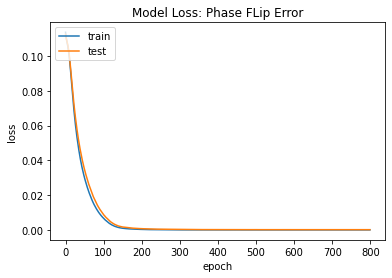

In [47]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_threeq(y_prediction, y_test)
fidn = fid_threeq(y_test, x_test)


print(tf.math.reduce_mean(fid))

tf.Tensor((0.99043983+2.7110217e-10j), shape=(), dtype=complex64)


## Infidelity

In [49]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(63,)),                                 
  tf.keras.layers.Dense(128, activation='relu'),
   tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(63),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(7.0) * tf.math.l2_normalize(x, axis=1))
  ])

# Compile model
adam_opt = tf.optimizers.Adam(0.0002)
model.compile(optimizer=adam_opt,
              loss=infidelity3)

In [50]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=800)

Epoch 1/800
9/9 [==============================] - 2s 43ms/step - loss: 0.8559 - val_loss: 0.8438
Epoch 2/800
9/9 [==============================] - 0s 14ms/step - loss: 0.8217 - val_loss: 0.8167
Epoch 3/800
9/9 [==============================] - 0s 16ms/step - loss: 0.7863 - val_loss: 0.7850
Epoch 4/800
9/9 [==============================] - 0s 13ms/step - loss: 0.7457 - val_loss: 0.7480
Epoch 5/800
9/9 [==============================] - 0s 14ms/step - loss: 0.7006 - val_loss: 0.7082
Epoch 6/800
9/9 [==============================] - 0s 16ms/step - loss: 0.6566 - val_loss: 0.6698
Epoch 7/800
9/9 [==============================] - 0s 14ms/step - loss: 0.6161 - val_loss: 0.6361
Epoch 8/800
9/9 [==============================] - 0s 14ms/step - loss: 0.5801 - val_loss: 0.6062
Epoch 9/800
9/9 [==============================] - 0s 16ms/step - loss: 0.5486 - val_loss: 0.5797
Epoch 10/800
9/9 [==============================] - 0s 18ms/step - loss: 0.5211 - val_loss: 0.5564
Epoch 11/800
9/9 [=

Epoch 84/800
9/9 [==============================] - 0s 13ms/step - loss: 0.0820 - val_loss: 0.1290
Epoch 85/800
9/9 [==============================] - 0s 17ms/step - loss: 0.0802 - val_loss: 0.1270
Epoch 86/800
9/9 [==============================] - 0s 15ms/step - loss: 0.0786 - val_loss: 0.1249
Epoch 87/800
9/9 [==============================] - 0s 16ms/step - loss: 0.0769 - val_loss: 0.1227
Epoch 88/800
9/9 [==============================] - 0s 14ms/step - loss: 0.0755 - val_loss: 0.1207
Epoch 89/800
9/9 [==============================] - 0s 14ms/step - loss: 0.0739 - val_loss: 0.1188
Epoch 90/800
9/9 [==============================] - 0s 14ms/step - loss: 0.0724 - val_loss: 0.1165
Epoch 91/800
9/9 [==============================] - 0s 14ms/step - loss: 0.0708 - val_loss: 0.1148
Epoch 92/800
9/9 [==============================] - 0s 14ms/step - loss: 0.0694 - val_loss: 0.1127
Epoch 93/800
9/9 [==============================] - 0s 17ms/step - loss: 0.0679 - val_loss: 0.1108
Epoch 94/8

9/9 [==============================] - 0s 16ms/step - loss: 0.0173 - val_loss: 0.0332
Epoch 167/800
9/9 [==============================] - 0s 15ms/step - loss: 0.0170 - val_loss: 0.0327
Epoch 168/800
9/9 [==============================] - 0s 17ms/step - loss: 0.0167 - val_loss: 0.0322
Epoch 169/800
9/9 [==============================] - 0s 15ms/step - loss: 0.0164 - val_loss: 0.0317
Epoch 170/800
9/9 [==============================] - 0s 16ms/step - loss: 0.0162 - val_loss: 0.0315
Epoch 171/800
9/9 [==============================] - 0s 17ms/step - loss: 0.0160 - val_loss: 0.0310
Epoch 172/800
9/9 [==============================] - 0s 18ms/step - loss: 0.0158 - val_loss: 0.0306
Epoch 173/800
9/9 [==============================] - 0s 13ms/step - loss: 0.0155 - val_loss: 0.0302
Epoch 174/800
9/9 [==============================] - 0s 16ms/step - loss: 0.0153 - val_loss: 0.0297
Epoch 175/800
9/9 [==============================] - 0s 14ms/step - loss: 0.0150 - val_loss: 0.0293
Epoch 176/800


9/9 [==============================] - 0s 14ms/step - loss: 0.0051 - val_loss: 0.0109
Epoch 249/800
9/9 [==============================] - 0s 16ms/step - loss: 0.0050 - val_loss: 0.0108
Epoch 250/800
9/9 [==============================] - 0s 18ms/step - loss: 0.0049 - val_loss: 0.0106
Epoch 251/800
9/9 [==============================] - 0s 17ms/step - loss: 0.0048 - val_loss: 0.0104
Epoch 252/800
9/9 [==============================] - 0s 13ms/step - loss: 0.0047 - val_loss: 0.0103
Epoch 253/800
9/9 [==============================] - 0s 17ms/step - loss: 0.0047 - val_loss: 0.0102
Epoch 254/800
9/9 [==============================] - 0s 18ms/step - loss: 0.0046 - val_loss: 0.0100
Epoch 255/800
9/9 [==============================] - 0s 16ms/step - loss: 0.0045 - val_loss: 0.0100
Epoch 256/800
9/9 [==============================] - 0s 17ms/step - loss: 0.0045 - val_loss: 0.0099
Epoch 257/800
9/9 [==============================] - 0s 19ms/step - loss: 0.0044 - val_loss: 0.0096
Epoch 258/800


9/9 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 331/800
9/9 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 332/800
9/9 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 333/800
9/9 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 334/800
9/9 [==============================] - 0s 19ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 335/800
9/9 [==============================] - 0s 18ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 336/800
9/9 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 337/800
9/9 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 338/800
9/9 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 339/800
9/9 [==============================] - 0s 16ms/step - loss: 0.0010 - val_loss: 0.0032
Epoch 340/800


9/9 [==============================] - 0s 25ms/step - loss: 2.6585e-04 - val_loss: 0.0016
Epoch 410/800
9/9 [==============================] - 0s 24ms/step - loss: 2.5513e-04 - val_loss: 0.0016
Epoch 411/800
9/9 [==============================] - 0s 23ms/step - loss: 2.4867e-04 - val_loss: 0.0015
Epoch 412/800
9/9 [==============================] - 0s 24ms/step - loss: 2.4027e-04 - val_loss: 0.0015
Epoch 413/800
9/9 [==============================] - 0s 32ms/step - loss: 2.3723e-04 - val_loss: 0.0015
Epoch 414/800
9/9 [==============================] - 0s 31ms/step - loss: 2.3178e-04 - val_loss: 0.0015
Epoch 415/800
9/9 [==============================] - 0s 23ms/step - loss: 2.2999e-04 - val_loss: 0.0015
Epoch 416/800
9/9 [==============================] - 0s 25ms/step - loss: 2.2165e-04 - val_loss: 0.0015
Epoch 417/800
9/9 [==============================] - 0s 21ms/step - loss: 2.1552e-04 - val_loss: 0.0015
Epoch 418/800
9/9 [==============================] - 0s 19ms/step - loss: 2.16

Epoch 488/800
9/9 [==============================] - 0s 19ms/step - loss: 5.9327e-05 - val_loss: 9.9248e-04
Epoch 489/800
9/9 [==============================] - 0s 18ms/step - loss: 5.7397e-05 - val_loss: 9.8281e-04
Epoch 490/800
9/9 [==============================] - 0s 14ms/step - loss: 5.6943e-05 - val_loss: 9.8649e-04
Epoch 491/800
9/9 [==============================] - 0s 15ms/step - loss: 5.4738e-05 - val_loss: 9.7670e-04
Epoch 492/800
9/9 [==============================] - 0s 17ms/step - loss: 5.3263e-05 - val_loss: 9.7661e-04
Epoch 493/800
9/9 [==============================] - 0s 14ms/step - loss: 5.3664e-05 - val_loss: 9.7964e-04
Epoch 494/800
9/9 [==============================] - 0s 18ms/step - loss: 6.0262e-05 - val_loss: 9.6583e-04
Epoch 495/800
9/9 [==============================] - 0s 18ms/step - loss: 5.5812e-05 - val_loss: 9.6124e-04
Epoch 496/800
9/9 [==============================] - 0s 18ms/step - loss: 4.9446e-05 - val_loss: 9.7447e-04
Epoch 497/800
9/9 [=========

Epoch 564/800
9/9 [==============================] - 0s 15ms/step - loss: 4.5224e-05 - val_loss: 8.3712e-04
Epoch 565/800
9/9 [==============================] - 0s 14ms/step - loss: 3.3600e-05 - val_loss: 8.4423e-04
Epoch 566/800
9/9 [==============================] - 0s 13ms/step - loss: 4.8312e-05 - val_loss: 8.1886e-04
Epoch 567/800
9/9 [==============================] - 0s 12ms/step - loss: 2.7116e-05 - val_loss: 8.3230e-04
Epoch 568/800
9/9 [==============================] - 0s 14ms/step - loss: 2.8718e-05 - val_loss: 8.2468e-04
Epoch 569/800
9/9 [==============================] - 0s 19ms/step - loss: 3.1780e-05 - val_loss: 8.5115e-04
Epoch 570/800
9/9 [==============================] - 0s 27ms/step - loss: 3.6144e-05 - val_loss: 8.2439e-04
Epoch 571/800
9/9 [==============================] - 0s 22ms/step - loss: 2.9911e-05 - val_loss: 8.1130e-04
Epoch 572/800
9/9 [==============================] - 0s 22ms/step - loss: 2.0830e-05 - val_loss: 8.2139e-04
Epoch 573/800
9/9 [=========

Epoch 640/800
9/9 [==============================] - 0s 19ms/step - loss: 1.9405e-05 - val_loss: 7.7416e-04
Epoch 641/800
9/9 [==============================] - 0s 17ms/step - loss: 1.2664e-05 - val_loss: 7.7621e-04
Epoch 642/800
9/9 [==============================] - 0s 16ms/step - loss: 2.2940e-05 - val_loss: 8.1326e-04
Epoch 643/800
9/9 [==============================] - 0s 15ms/step - loss: 1.3786e-04 - val_loss: 8.3215e-04
Epoch 644/800
9/9 [==============================] - 0s 15ms/step - loss: 1.2953e-04 - val_loss: 8.3989e-04
Epoch 645/800
9/9 [==============================] - 0s 14ms/step - loss: 9.2781e-05 - val_loss: 8.2503e-04
Epoch 646/800
9/9 [==============================] - 0s 15ms/step - loss: 3.0703e-05 - val_loss: 7.7581e-04
Epoch 647/800
9/9 [==============================] - 0s 15ms/step - loss: 2.3273e-05 - val_loss: 7.7775e-04
Epoch 648/800
9/9 [==============================] - 0s 15ms/step - loss: 1.2757e-05 - val_loss: 7.7376e-04
Epoch 649/800
9/9 [=========

Epoch 716/800
9/9 [==============================] - 0s 16ms/step - loss: 8.7996e-05 - val_loss: 7.7877e-04
Epoch 717/800
9/9 [==============================] - 0s 15ms/step - loss: 2.7119e-05 - val_loss: 8.1681e-04
Epoch 718/800
9/9 [==============================] - 0s 14ms/step - loss: 4.7842e-05 - val_loss: 8.2314e-04
Epoch 719/800
9/9 [==============================] - 0s 15ms/step - loss: 4.3492e-05 - val_loss: 8.2182e-04
Epoch 720/800
9/9 [==============================] - 0s 14ms/step - loss: 6.0242e-05 - val_loss: 7.7230e-04
Epoch 721/800
9/9 [==============================] - 0s 14ms/step - loss: 2.1439e-05 - val_loss: 7.8069e-04
Epoch 722/800
9/9 [==============================] - 0s 14ms/step - loss: 8.6558e-06 - val_loss: 7.6430e-04
Epoch 723/800
9/9 [==============================] - 0s 13ms/step - loss: 7.3602e-06 - val_loss: 7.6455e-04
Epoch 724/800
9/9 [==============================] - 0s 13ms/step - loss: 5.3823e-06 - val_loss: 7.7417e-04
Epoch 725/800
9/9 [=========

Epoch 792/800
9/9 [==============================] - 0s 19ms/step - loss: 2.9594e-06 - val_loss: 7.7787e-04
Epoch 793/800
9/9 [==============================] - 0s 19ms/step - loss: 1.3473e-06 - val_loss: 7.7580e-04
Epoch 794/800
9/9 [==============================] - 0s 18ms/step - loss: 8.4976e-07 - val_loss: 7.7433e-04
Epoch 795/800
9/9 [==============================] - 0s 21ms/step - loss: 7.2870e-07 - val_loss: 7.7386e-04
Epoch 796/800
9/9 [==============================] - 0s 16ms/step - loss: 8.2407e-07 - val_loss: 7.7318e-04
Epoch 797/800
9/9 [==============================] - 0s 14ms/step - loss: 7.7903e-07 - val_loss: 7.7220e-04
Epoch 798/800
9/9 [==============================] - 0s 15ms/step - loss: 8.7056e-07 - val_loss: 7.7175e-04
Epoch 799/800
9/9 [==============================] - 0s 14ms/step - loss: 1.5656e-06 - val_loss: 7.7297e-04
Epoch 800/800
9/9 [==============================] - 0s 13ms/step - loss: 4.0185e-06 - val_loss: 7.7601e-04


In [51]:
score = model.evaluate(x_test,  y_test, verbose=2)

16/16 - 0s - loss: 7.8952e-04 - 272ms/epoch - 17ms/step


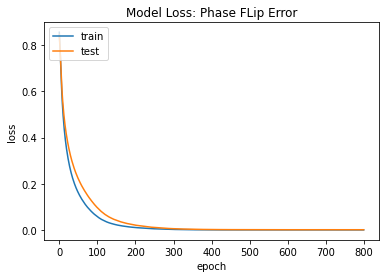

In [52]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_threeq(y_prediction, y_test)
fidn = fid_threeq(y_test, x_test)


print(tf.math.reduce_mean(fid))

tf.Tensor((0.9992105-9.599899e-11j), shape=(), dtype=complex64)


In [55]:
#comparison
print(y_prediction[1])
print(y_test[1])

[-0.2297293245792389, -0.6807445287704468, -0.021161658689379692, -0.3137222230434418, -0.28373223543167114, 0.481995552778244, 0.01051648985594511, 0.2682323157787323, -0.3190387487411499, -0.1424635499715805, 0.05291803553700447, 0.6023198962211609, -0.166717991232872, -0.39185360074043274, -0.13445411622524261, 0.13248293101787567, 0.5062273144721985, -0.437107115983963, 0.051551371812820435, -0.5881977081298828, 0.09392572939395905, 0.38535937666893005, -0.0347139909863472, -0.3328912854194641, 0.2257883995771408, 0.2183832973241806, 0.01238592341542244, 0.0350375697016716, 0.28776082396507263, -0.30796611309051514, 0.08364740014076233, 0.2630240321159363, 0.02149713970720768, -0.28202876448631287, -0.4528489112854004, -0.33817818760871887, 0.07393835484981537, 0.389081209897995, 0.07421287149190903, 0.35792431235313416, -0.3340495228767395, -0.5102249383926392, -0.12378498911857605, -0.0732421725988388, 0.09070361405611038, 0.05003642290830612, -0.6627426743507385, 0.5052626729011